In [1]:
# imports
import logging
import os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import base64
import tensorflow as tf
import foolbox as fb

In [10]:
# convert the cat pictures and save them
def load_and_serialize_picture(inpath, outpath):
    """ Reads an image from given path and encodes it. """
    img_unprepared = tf.keras.preprocessing.image.load_img(inpath)
    img = tf.keras.preprocessing.image.img_to_array(img_unprepared) / 255.0

    assert img.shape == (180, 180, 3)

    with open(outpath, "w") as f:
        towrite = base64.b64encode(tf.io.serialize_tensor(img).numpy()).decode()
        f.write(towrite)

if not os.path.isdir("pics"):        
    os.mkdir("pics")
load_and_serialize_picture("my-cat-pictures/cat1.png", "pics/cat1")
load_and_serialize_picture("my-cat-pictures/cat2.png", "pics/cat2")
load_and_serialize_picture("my-cat-pictures/cat3.png", "pics/cat3")

In [9]:
# load the cat pictures
# obviously saving and loading to a file isn't necessary 
# but it's nice to have them around
def load_and_deserialize_picture(path):
    with open(path, "rb") as reader:
        data = reader.read()

    return tf.io.parse_tensor(base64.b64decode(data), out_type=tf.float32)


cats = [load_and_deserialize_picture("pics/cat1"),
        load_and_deserialize_picture("pics/cat2"),
        load_and_deserialize_picture("pics/cat3")]

catz = tf.convert_to_tensor(cats)

In [12]:
# import our model and make a foolbox model from it
model = tf.keras.models.load_model("./tf-model")
# our original model already had tensors in between 0 and 1 
# so luckily we don't need to do any transformations for foolbox
fmodel = fb.TensorFlowModel(model, bounds=(0,1))

# dogez is how we tell foolbox to target category 3 (doges) in the model
dogs = tf.convert_to_tensor([3,3,3])
dogez = fb.criteria.TargetedMisclassification(dogs)

In [14]:
# actually run the attack, while keeping our output no more than 
# .02 distance from our original image (requirement is .25)
attack = fb.attacks.LinfProjectedGradientDescentAttack()
raw, clipped, is_adv = attack(fmodel, catz, dogez, epsilons=.020)

In [15]:
# did the attack work?
is_adv

<tf.Tensor: shape=(3,), dtype=bool, numpy=array([ True,  True,  True])>

In [16]:
# then lets save the pictures!
def save_catz(tens):
    for i in range(3):
        with open("out/cat" + str(i+1), "w") as f:
            f.write(base64.b64encode(tf.io.serialize_tensor(tens[i]).numpy()).decode())

if not os.path.isdir("out"):
    os.mkdir("out")            
            
# note that raw and clipped are both outputs of attack, 
# but clipped is the output that stays within the bounds 
# we set for it (.02), a requirement for testing
save_catz(clipped)   

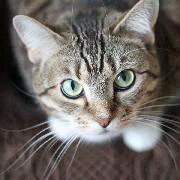

In [18]:
# the first adversarially generated cat
tf.keras.preprocessing.image.array_to_img(clipped[0]*255)